# CITE-seq reference mapping with totalVI

With totalVI, we can train a reference model that can be used for mapping new query data. Here we dive into this functionality.

If you use totalVI, please consider citing:

* Gayoso, A., Steier, Z., Lopez, R., Regier, J., Nazor, K. L., Streets, A., & Yosef, N. (2021). Joint probabilistic modeling of single-cell multi-omic data with totalVI. Nature Methods, 18(3), 272-282.


In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

if IN_COLAB:
    !pip install --quiet scrublet
    !pip install --upgrade numba

     |████████████████████████████████| 56 kB 2.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.4 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 813 kB 7.3 MB/s 
     |████████████████████████████████| 242 kB 64.7 MB/s 
     |████████████████████████████████| 127 kB 76.1 MB/s 
     |████████████████████████████████| 678 kB 47.5 MB/s 
     |████████████████████████████████| 211 kB 86.7 MB/s 
     |████████████████████████████████| 2.0 MB 52.4 MB/s 
     |████████████████████████████████| 8.8 MB 37.1 MB/s 
     |████████████████████████████████| 3.2 MB 61.7 MB/s 
     |████████████████████████████████| 1.4 MB 58.3 MB/s 
     |████████████

## Building a reference model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scvi
import scanpy as sc

from scvi.model import TOTALVI

sc.set_figure_params(figsize=(4, 4))

Global seed set to 0


This dataset was filtered as described in the scvi-tools manuscript (low quality cells, doublets, lowly expressed genes, etc.).

<div class="alert alert-info">

Note

Here we use the argument `mask_protein_batches=5`. What this does is treats the protein data in 5/24 of the batches in this dataset as missing. This will help totalVI integrate query data that has a subset of the proteins measured in this dataset or no proteins at all (i.e., just scRNA-seq data).

</div>

In [3]:
adata = scvi.data.pbmc_seurat_v4_cite_seq(
    run_setup_anndata=False,
    mask_protein_batches=5,
)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

INFO     Downloading file at data/pbmc_seurat_v4.h5ad                                        
Downloading...: 100%|██████████| 1002579/1002579.0 [00:52<00:00, 19148.32it/s]


In [4]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=4000, 
    flavor="seurat_v3",
    batch_key="orig.ident", 
    subset=True,
    layer="counts"
)

In [5]:
adata

AnnData object with n_obs × n_vars = 152094 × 4000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Protein log library size', 'Number proteins detected', 'RNA log library size'
    var: 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    obsm: 'protein_counts'
    layers: 'counts'

In [6]:
TOTALVI.setup_anndata(
    adata, 
    layer="counts", 
    batch_key="orig.ident", 
    protein_expression_obsm_key="protein_counts"
)

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Using protein expression from adata.obsm['protein_counts']                          
INFO     Using protein names from columns of adata.obsm['protein_counts']                    
INFO     Found batches with missing protein expression                                       
INFO     Successfully registered anndata object containing 152094 cells, 4000 vars, 24       
         batches, 1 labels, and 217 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


### Prepare and run model


Here we use the scArches-specific totalVI parameters, as shown in the scArches tutorial.

Rather than training the model here, which would take 1 hour, we instead download a pretrained object.

In [ ]:
# # training code here
# arches_params = dict(
#     use_layer_norm="both",
#     use_batch_norm="none",
#     n_layers_decoder=2,
#     n_layers_encoder=2,
# )

# vae = TOTALVI(adata, **arches_params)
# vae.train(max_epochs=250)
# vae.save("seurat_reference_model", overwrite=True)

In [7]:
%%capture
!wget https://figshare.com/ndownloader/files/30929902 -O seurat_reference_model.zip
!unzip seurat_reference_model.zip
vae = TOTALVI.load("seurat_reference_model", adata)

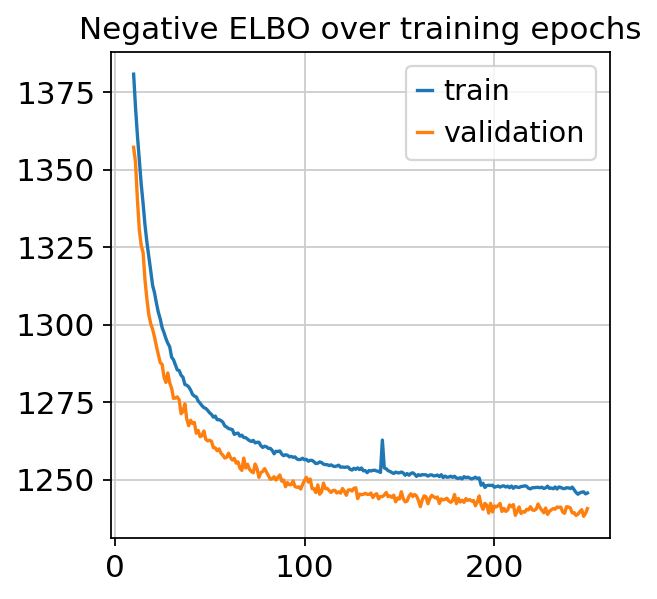

In [11]:
plt.plot(vae.history["elbo_train"].iloc[10:], label="train")
plt.plot(vae.history["elbo_validation"].iloc[10:], label="validation")
plt.title("Negative ELBO over training epochs")
plt.legend()

In [12]:
adata.obsm["X_totalvi_scarches"] = vae.get_latent_representation()

### Train a classifier on the latent space

The representation of the reference data will not change when the model gets updated with query data. Therefore, we can train any simple classifier on the latent space. Here we use a Random Forest from scikit-learn.

By storing the classifier object in our totalVI instance (and giving it an attribute that ends with `_`), we can automatically save and load this classifier along with our model.

In [14]:
from sklearn.ensemble import RandomForestClassifier

y_train = adata.obs["celltype.l2"].astype("category").cat.codes.to_numpy()
X_train = adata.obsm["X_totalvi_scarches"]
clf = RandomForestClassifier(
    random_state=1, 
    class_weight = "balanced_subsample",
    verbose=1,
    n_jobs=-1,
)
clf.fit(X_train, y_train)

vae.latent_space_classifer_ = clf

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.2s finished
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc53b8546e0>


### Inspect reference model

We can view the latent space using UMAP and plot the study-derived cell type labels.

Here we use the umap API instead of scanpy so that we can later use the same umap object on the query data.

In [16]:
import umap

X = adata.obsm["X_totalvi_scarches"]
trans = umap.UMAP(
    n_neighbors=10, 
    random_state=42,
    min_dist=0.4,
)
adata.obsm["X_umap"] = trans.fit_transform(X)

vae.umap_op_ = trans

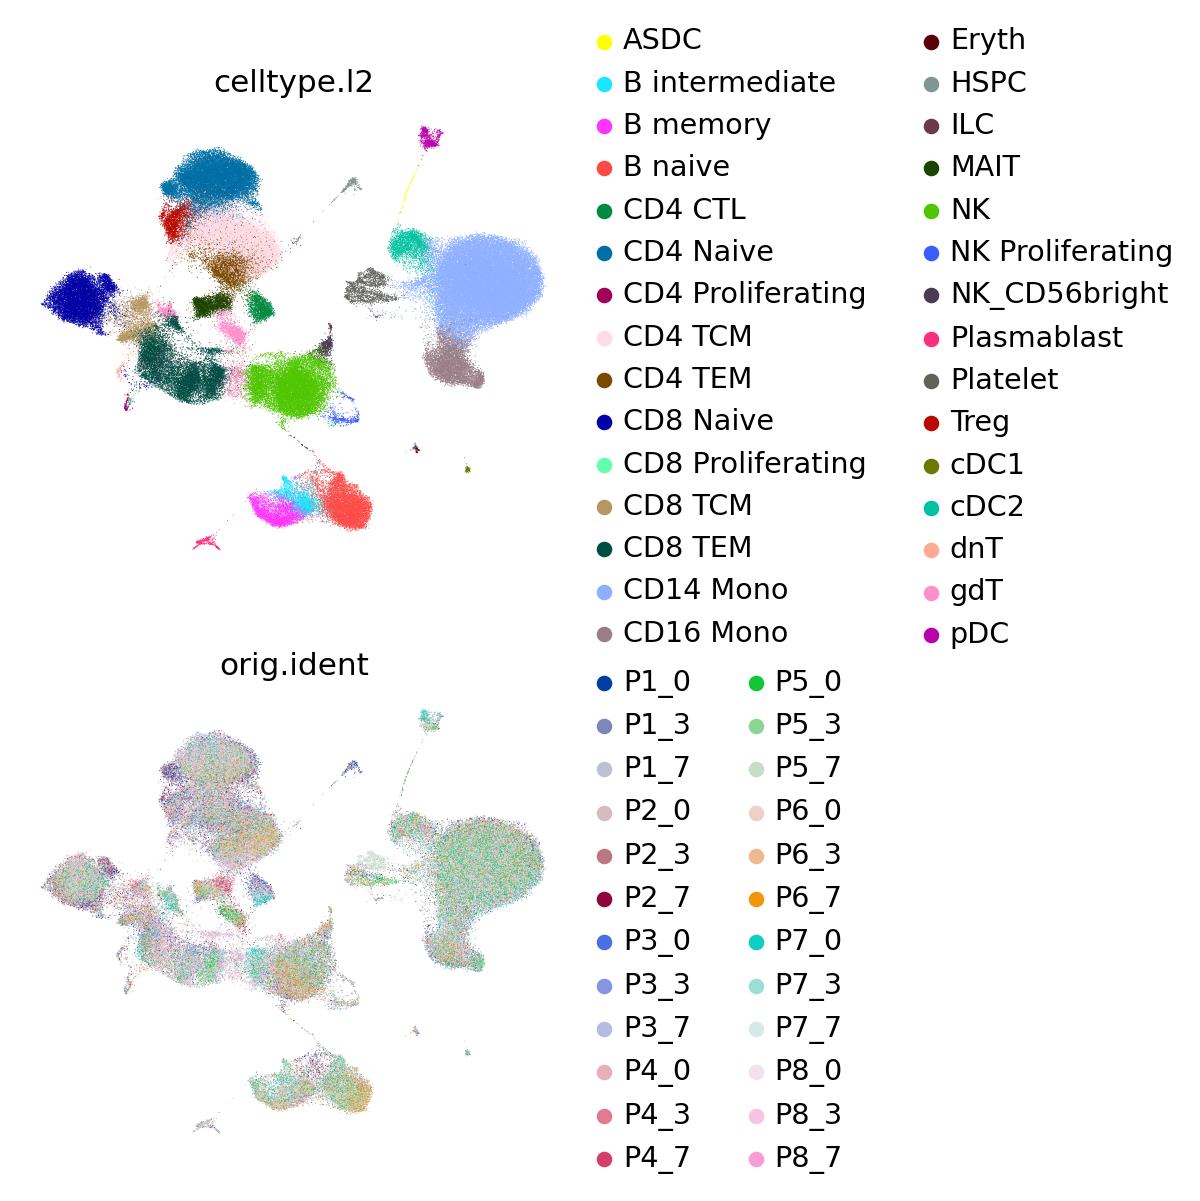

In [17]:
sc.pl.umap(
    adata, 
    color=["celltype.l2", "orig.ident"], 
    frameon=False,
    ncols=1,
)

## Map query data

Now we download our query data and cover the preprocessing necessary to map with our reference model.

In this case our query data are also PBMCs and come from the following study:

* Arunachalam, Prabhu S., et al. "Systems biological assessment of immunity to mild versus severe COVID-19 infection in humans." Science 369.6508 (2020): 1210-1220.

This dataset is also CITE-seq, but contains a subset of the proteins of the reference data.

In [19]:
query = sc.read("data/covid_cite.h5ad", backup_url="https://ndownloader.figshare.com/files/27458837")

  0%|          | 0.00/289M [00:00<?, ?B/s]

### Preprocessing

First we remove any doublets from the query dataset using Scrublet. This has to be run per batch, which in this dataset is denoted with `"set"`.

In [20]:
import scrublet as scr

query.obs["doublet_scores"] = 0
query.obs["predicted_doublets"] = True
for s in np.unique(query.obs["set"]):
    mask = query.obs["set"] == s
    counts_matrix = query[mask].X.copy()
    scrub = scr.Scrublet(counts_matrix)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    query.obs["doublet_scores"].iloc[mask] = doublet_scores
    query.obs["predicted_doublets"].iloc[mask] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Automatically set threshold at doublet score = 0.36
Detected doublet rate = 3.8%
Estimated detectable doublet fraction = 41.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.2%
Elapsed time: 50.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 6.4%
Estimated detectable doublet fraction = 57.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.1%
Elapsed time: 50.2 seconds


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Next we do the following:

1. Store the counts in a layer, perform standard preprocessing
1. Add blank metadata that we will later fill in with predicted labels
1. Rename the batch key to correspond to the reference data
1. Add proteins with all 0 counts for the missing proteins in this query dataset

In [21]:
query.layers["counts"] = query.X.copy()
sc.pp.normalize_total(query, target_sum=1e4)
sc.pp.log1p(query)
query.raw = query
# subset to reference vars
query = query[:, adata.var_names].copy()

query.obsm["protein_counts"] = query.obsm["pro_exp"].copy()
query.obs["celltype.l2"] = "Unknown"
query.obs["orig.ident"] = query.obs["set"]
query.obsm["X_umap"] = query.obs[["UMAP1", "UMAP2"]]

# reorganize query proteins, missing proteins become all 0
for p in adata.obsm["protein_counts"].columns:
    if p not in query.obsm["protein_counts"].columns:
        query.obsm["protein_counts"][p] = 0.0
# ensure columns are in same order
query.obsm["protein_counts"] = query.obsm["protein_counts"].loc[:, adata.obsm["protein_counts"].columns]

For later visualization, we add some metadata to denote whether the dataset is reference of query

In [22]:
adata.obs["dataset_name"] = "Reference"
query.obs["dataset_name"] = "Query"

### Query model training

In [23]:
vae_q = scvi.model.TOTALVI.load_query_data(
    query, 
    vae,
)
vae_q.train(
    max_epochs=150, 
    plan_kwargs=dict(
        weight_decay=0.0,
        scale_adversarial_loss=0.0
    ),
)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Found batches with missing protein expression                                       
INFO     Using data from adata.layers["counts"]                                              


/usr/local/lib/python3.7/dist-packages/scvi/model/base/_archesmixin.py:96: UserWarning: Query integration should be performed using models trained with version >= 0.8
  "Query integration should be performed using models trained with version >= 0.8"


INFO     Registered keys:['X', 'batch_indices', 'labels', 'protein_expression']              
INFO     Successfully registered anndata object containing 57669 cells, 4000 vars, 26        
         batches, 1 labels, and 217 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 150/150: 100%|██████████| 150/150 [12:53<00:00,  5.16s/it, loss=501, v_num=1]


And now we retrieve the latent representation for the query data

In [24]:
query.obsm["X_totalvi_scarches"] = vae_q.get_latent_representation(query)

### Query cell type prediction

We can use the random forest that we previously trained using the latent representation of the query data in the updated model!

In [25]:
# predict cell types of query
predictions = (
    vae_q.latent_space_classifer_.predict(
        query.obsm["X_totalvi_scarches"]
    )
)
categories = adata.obs["celltype.l2"].astype("category").cat.categories
cat_preds = [categories[i] for i in predictions]
query.obs["celltype.l2"] = cat_preds
query.obs["predicted_l2_scarches"] = cat_preds

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc4ac7ccde0>


### Evaluate label transfer

Now we plot the predicted labels and the labels from the query study (here denoted as `"final_clust_review"`) on the UMAP coordinated used in the query study. We can see that we have an overall strong concordance, but also some important differences. For example, the study found a population of monocytes with interferon signaling, but as the reference contains no such cell type, it can only predict them to be CD14 monocytes.

... storing 'celltype.l2' as categorical
... storing 'dataset_name' as categorical
... storing 'predicted_l2_scarches' as categorical


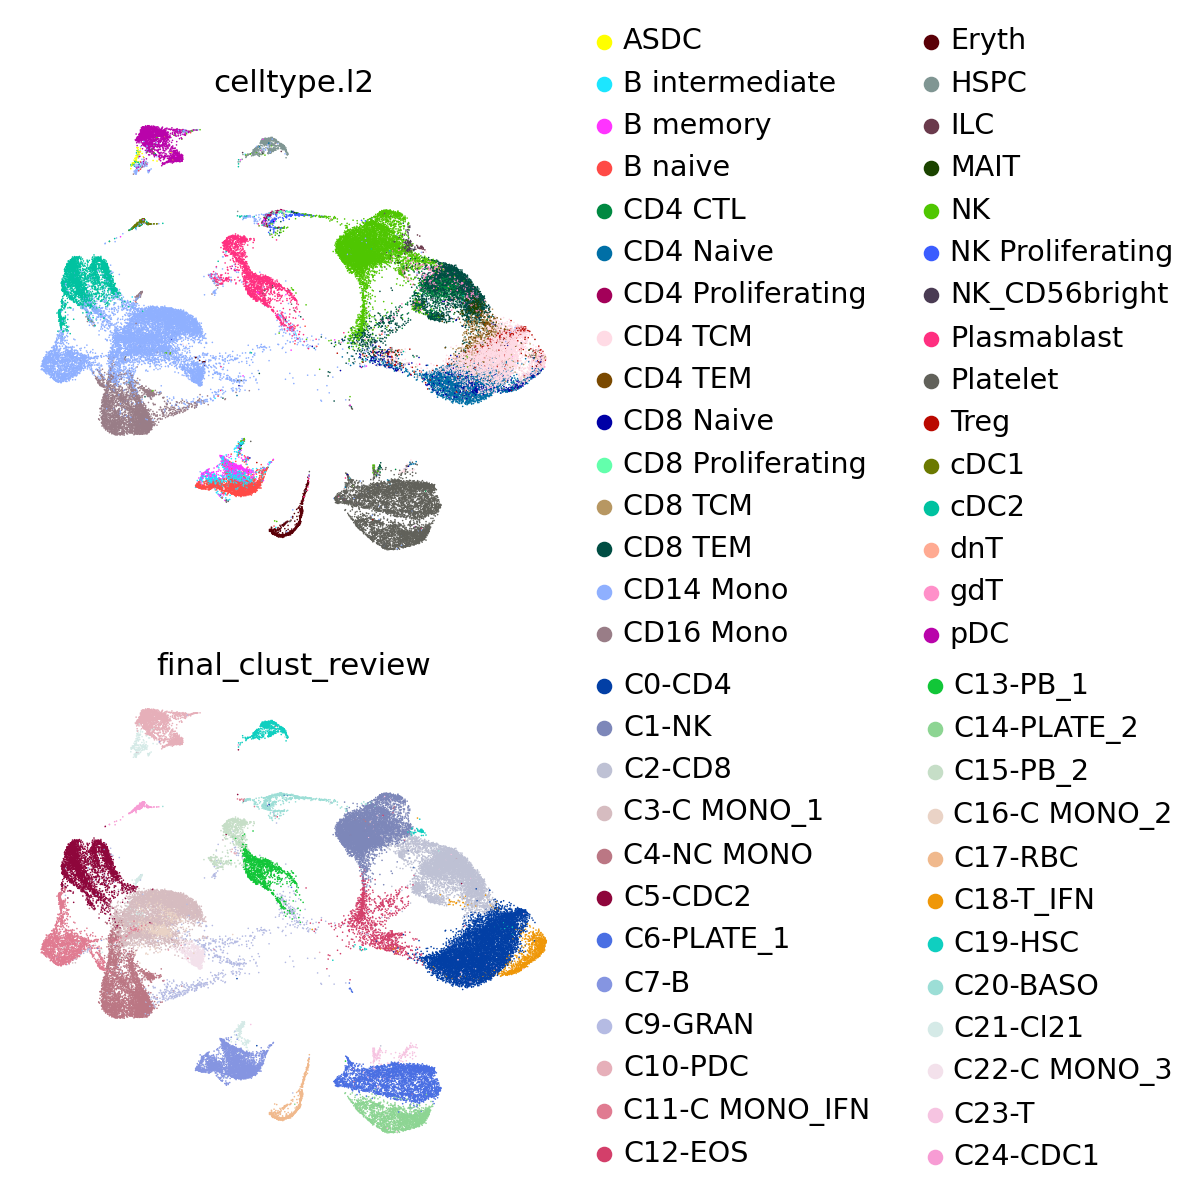

In [26]:
sc.pl.umap(
    query, 
    color=["celltype.l2", "final_clust_review"], 
    frameon=False,
    ncols=1,
)

### Use reference UMAP

We can also use the same UMAP operator from the reference step to visualize our query data.

In [27]:
query.obsm["X_umap_project"] = vae_q.umap_op_.transform(
    query.obsm["X_totalvi_scarches"]
)

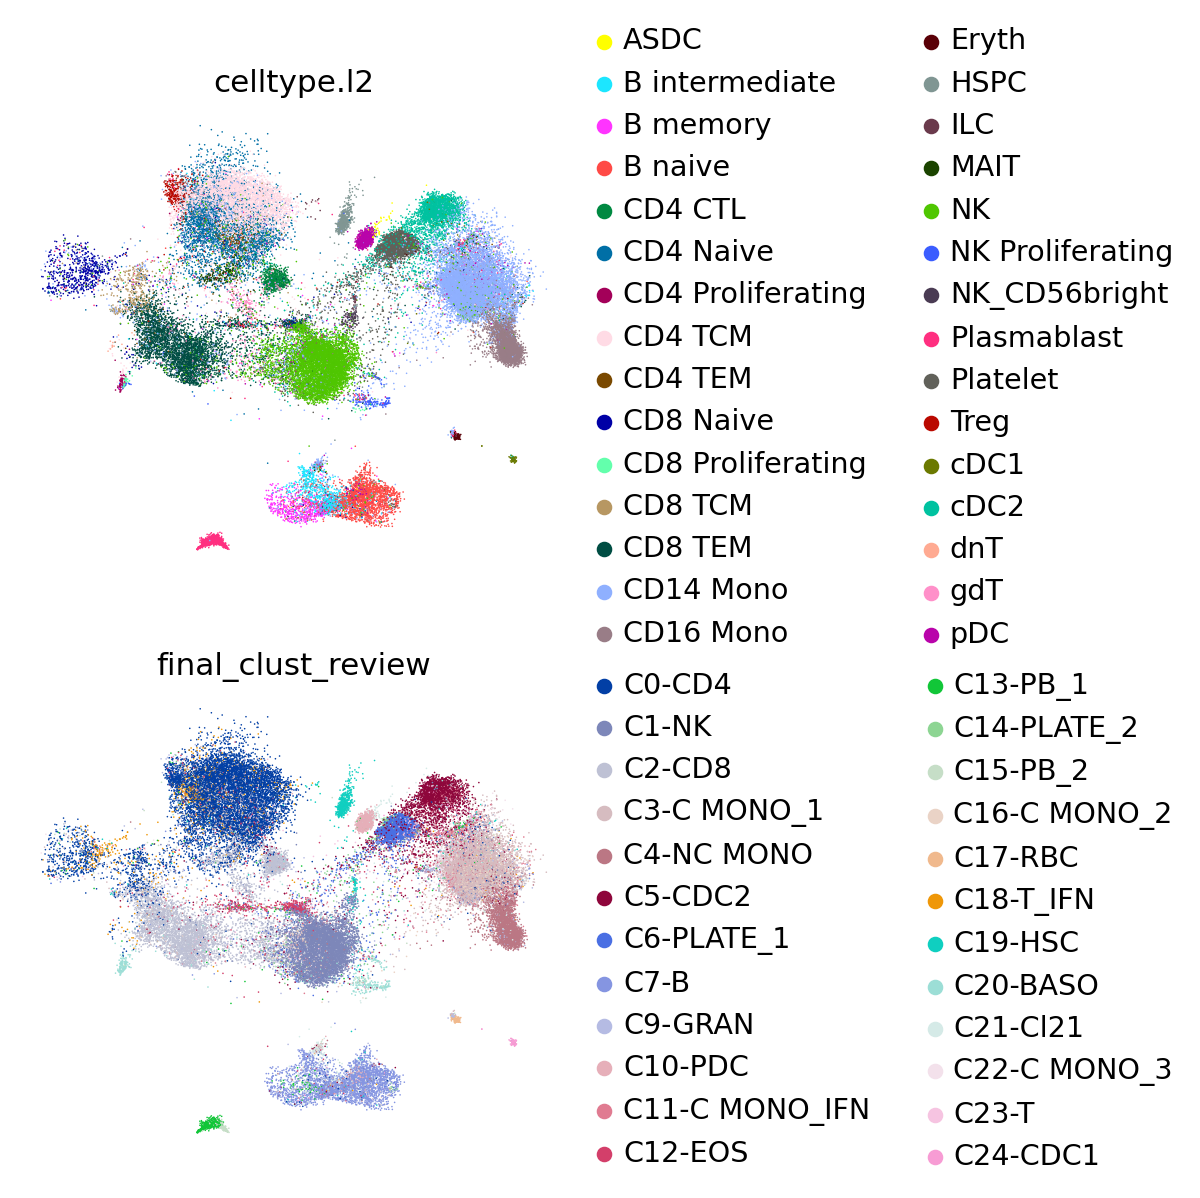

In [29]:
sc.pl.embedding(
    query,
    "X_umap_project",
    color=["celltype.l2", "final_clust_review"], 
    frameon=False,
    ncols=1,
)

And finally we can combine the umaps together and visualize jointly.

In [33]:
umap_adata = sc.AnnData(
    np.concatenate(
        [
         query.obsm["X_umap_project"], 
         adata.obsm["X_umap"], 
        ],
        axis=0
    )
)
umap_adata.obs["celltype"] = np.concatenate(
    [
     query.obs["celltype.l2"].values,
     adata.obs["celltype.l2"].values
    ]
)
umap_adata.obs["dataset"] = np.concatenate(
    [
     query.shape[0] * ["query"],
     adata.shape[0] * ["reference"]
    ]
)
umap_adata.obsm["X_umap"] = umap_adata.X

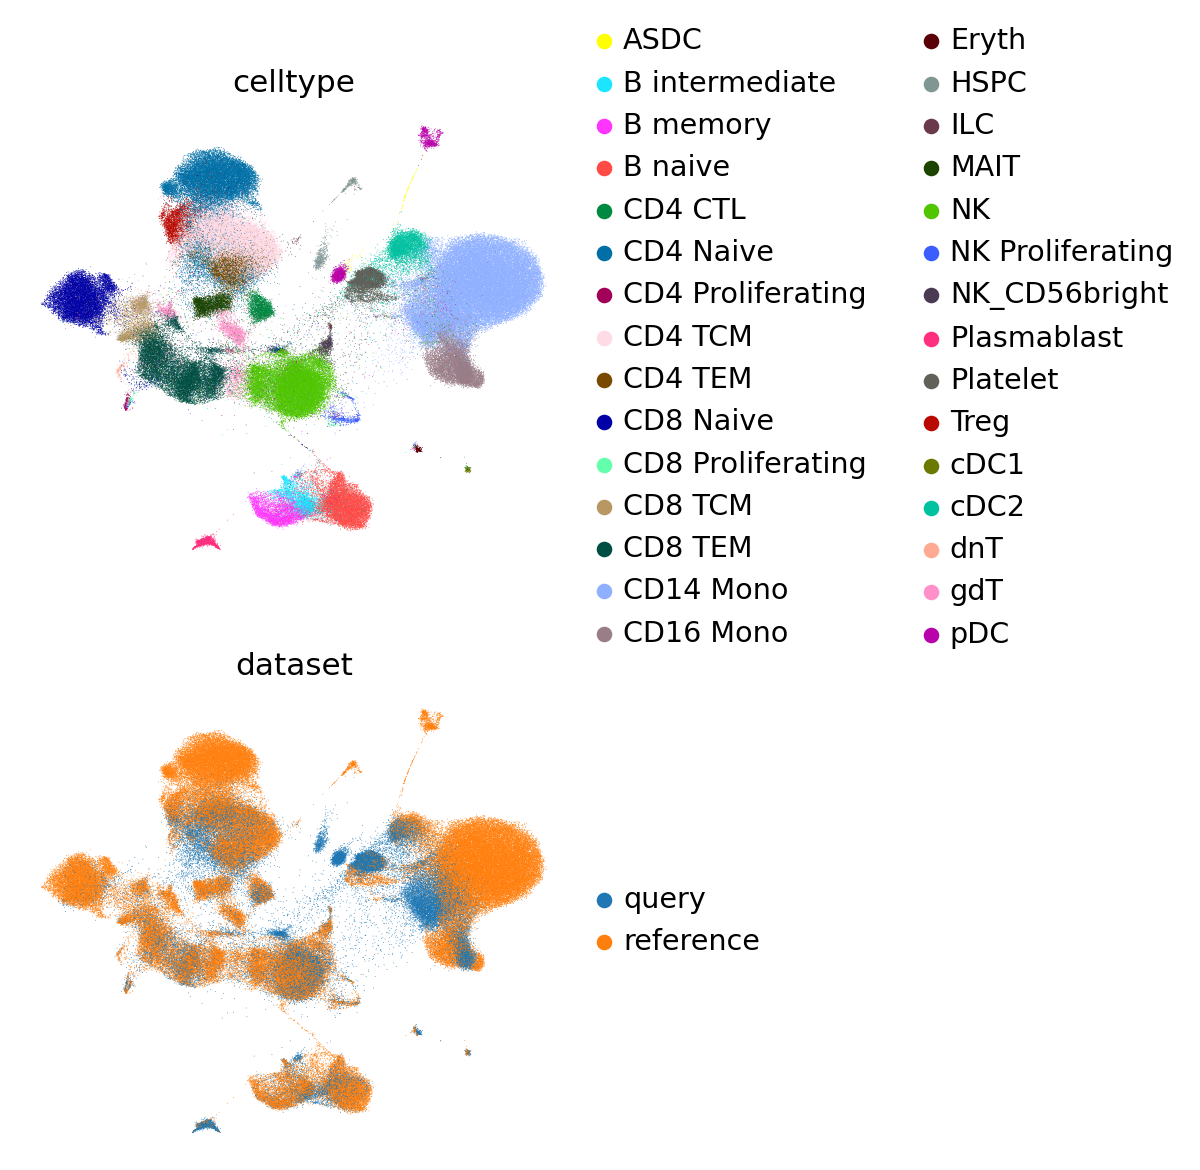

In [39]:
inds = np.random.permutation(np.arange(umap_adata.shape[0]))
sc.pl.umap(
    umap_adata[inds],
    color=["celltype", "dataset"], 
    frameon=False,
    ncols=1,
)